In [1]:
from pathlib import Path
import os
import sys

main_directory = Path(os.path.abspath("")).parent
sys.path.append(str(main_directory))

## Create a JSSP problem instance

In [2]:
from queasars.job_shop_scheduling.problem_instances import Machine, Operation, Job, JobShopSchedulingProblemInstance

machines = (Machine(name="m1"), Machine(name="m2"))

j1op1 = Operation(name="j1op1", machine=machines[0], processing_duration=1)
j1op2 = Operation(name="j1op2", machine=machines[1], processing_duration=1)
job1 = Job(name="j1", operations=(j1op1, j1op2))

j2op1 = Operation(name="j2op1", machine=machines[0], processing_duration=1)
j2op2 = Operation(name="j2op2", machine=machines[1], processing_duration=1)
job2 = Job(name="j2", operations=(j2op1, j2op2))

jssp_instance = JobShopSchedulingProblemInstance(name="jssp1", machines=machines, jobs=(job1, job2))

print(jssp_instance)

jssp1
  Machines:
    m1
    m2
  Jobs:
    j1:
      j1op1(m1, 1)
      j1op2(m2, 1)
    j2:
      j2op1(m1, 1)
      j2op2(m2, 1)


## Visualize the created problem instance (optional)

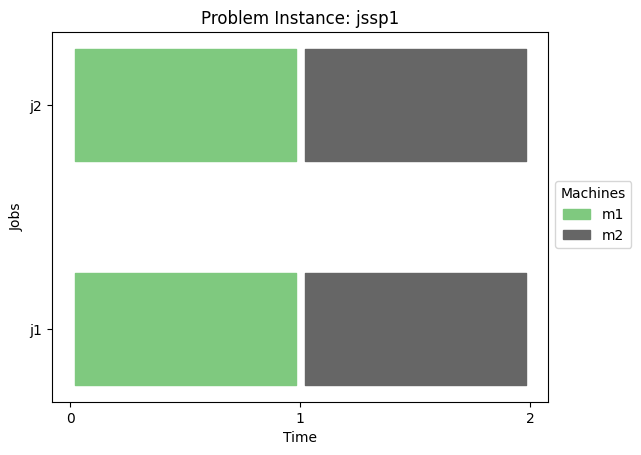

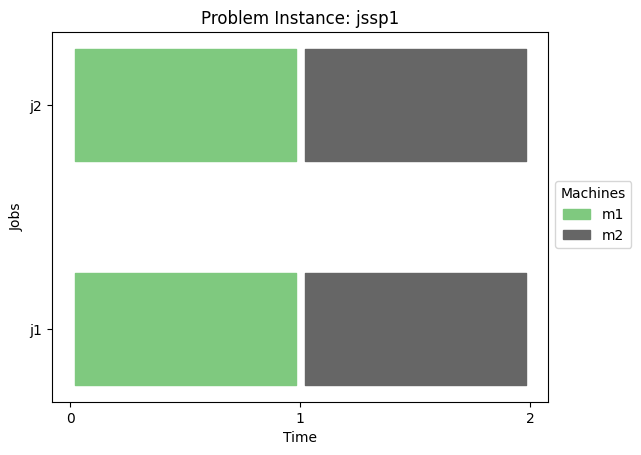

In [3]:
from queasars.job_shop_scheduling.visualization import plot_jssp_problem_instance_gantt

plot_jssp_problem_instance_gantt(problem_instance=jssp_instance)

## Convert the problem instance to a hamiltonian

In [4]:
from queasars.job_shop_scheduling.domain_wall_hamiltonian_encoder import JSSPDomainWallHamiltonianEncoder

encoder = JSSPDomainWallHamiltonianEncoder(jssp_instance=jssp_instance, time_limit=3, penalty=100)

print("needed qubits: ", encoder.n_qubits)

hamiltonian = encoder.get_problem_hamiltonian()

needed qubits:  4


## Setup and run the EVQEMinimumEigensolver

In [5]:
import logging
from concurrent.futures import ThreadPoolExecutor

from qiskit_algorithms.optimizers import SPSA
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator

from queasars.circuit_evaluation.mutex_primitives import BatchingMutexEstimator, BatchingMutexSampler
from queasars.minimum_eigensolvers.evqe.evqe import EVQEMinimumEigensolverConfiguration, EVQEMinimumEigensolver

# Connect to the runtime service using your IBM quantum token
runtime_service = QiskitRuntimeService(channel="ibm_quantum", token="f9bcdf9989d2b8febfaf8017578b2d66d08792485651e486bf401695f9385bdc143f5e3879a13cd7734ab94a55d53c1ad29723b27f0ddbaa65eec11e96074aff")

# Set up a session so that consecutive jobs may run in short succession.
# For this purpose a backend needs to be set. In this example the ibmq_qasm_simulator suffices.
# But one could also specify a real quantum backend for example like ibm_osaka.
with Session(service=runtime_service, backend="ibmq_qasm_simulator") as session:
    
    # Set up the Sampler and Estimator using the session.
    # Using as few shots and mitigation techniques as possible will reduce the runtime usage.
    thread_unsafe_sampler = Sampler(session=session, options={"shots": 100, "optimization_level": 0, "resilience_level": 0})
    thread_unsafe_estimator = Estimator(session=session, options={"shots": 100, "optimization_level": 0, "resilience_level": 0})
    
    # An executor for launching parallel computation needs to be specified.
    # This can be a dask Client or a python ThreadPoolExecutor. Dask will
    # provide a significantly better performance but needs the Sampler and
    # Estimator to be serializable by dask. On the other hand when using
    # the ThreadPoolExecutor, the Sampler and Estimator need to be threadsafe.
    # The ibm runtime primitives cannot be serialized, so we use a ThreadPoolExecutor.
    # We recommend to set the number of workers to the number individuals in the population.
    parallel_executor = ThreadPoolExecutor(max_workers=10)

    # Since the sampler and estimator need to be threadsafe when using the parallel_executor,
    # we wrap them to batch requests and guarantee mutual exclusion.
    sampler_primitive = BatchingMutexSampler(sampler=thread_unsafe_sampler, waiting_duration=0.1)
    estimator_primitive = BatchingMutexEstimator(estimator=thread_unsafe_estimator, waiting_duration=0.1)

    # The EVQEMinimumEigensolver also needs a qiskit optimizer. It should be
    # configured to terminate quickly, so that mutations are not overtly expensive.
    # Here we use the SPSA optimizer with a very limited amount of iterations and a
    # large step size.
    optimizer = SPSA(maxiter=3, perturbation=1.0, learning_rate=1.0, trust_region=True)
    
    # To help the EVQEMinimumEigensolver deal correctly with terminations based
    # on the amount of circuit evaluations used, an estimate can be given for how
    # many circuit evaluations the optimizer uses per optimization run.
    # SPSA makes two measurements per iteration, which means in total it will
    # need 6 circuit evaluations for 3 iterations.
    optimizer_n_circuit_evaluations = 6
    
    # To specify when the EVQEMinimumEigensolver should terminate either max_generations,
    # max_circuit_evaluations or a termination_criterion should be given.
    # Here we set a fixed generation limit, to reduce the runtime usage.
    max_generations = 3
    max_circuit_evaluations = None
    termination_criterion = None
    
    # A random seed can be provided to control the randomness of the evolutionary process.
    random_seed = 0
    
    # The population size determines how many individuals are evaluated each generation.
    # With a higher population size, fewer generations might be needed, but this also
    # makes each generation more expensive to evaluate.
    population_size = 5
    
    # If the optimization algorithm can't deal with parameter values of 0 at the beginning
    # of the optimization, they can be randomized here. For this example we don't need this.
    randomize_initial_population_parameters = False
    
    # Determines how many circuit layers apart two individuals need to be, to be considered to
    # be of a different species. Reasonable values might be in the range 2 - 5. Here we use 3.
    speciation_genetic_distance_threshold = 3
    
    # The alpha and beta penalties penalize quantum circuits of increasing depth (alpha) and
    # increasing amount of controlled rotations (beta). increase them if the quantum circuits get to
    # deep or complicated. For now we will use values of 0.1 for both penalties.
    selection_alpha_penalty = 0.1
    selection_beta_penalty = 0.1
    
    # The parameter search probability determines how likely an individual is mutated by optimizing
    # all it's parameter values. This should not be too large as this is costly. Here we will use
    # a probability of 0.25.
    parameter_search_probability = 0.25
    
    # The topological search probability determines how likely a circuit layer is added to an individual
    # as a mutation. This should be a higher probability to encourage exploration of different circuits.
    # Here we will use a likelihood of 0.5
    topological_search_probability = 0.5
    
    # The layer removal probability determines how likely circuit layers are removed from an individual
    # as a mutation. This is a very disruptive mutation and should only be used sparingly to counteract
    # circuit growth. Here we will use a probability of 0.1
    layer_removal_probability = 0.1
    
    configuration = EVQEMinimumEigensolverConfiguration(
        sampler=sampler_primitive,
        estimator=estimator_primitive,
        optimizer=optimizer,
        optimizer_n_circuit_evaluations=optimizer_n_circuit_evaluations,
        parallel_executor=parallel_executor,
        max_generations=max_generations,
        max_circuit_evaluations=max_circuit_evaluations,
        termination_criterion=termination_criterion,
        random_seed=random_seed,
        population_size=population_size,
        randomize_initial_population_parameters=randomize_initial_population_parameters,
        speciation_genetic_distance_threshold=speciation_genetic_distance_threshold,
        selection_alpha_penalty=selection_alpha_penalty,
        selection_beta_penalty=selection_beta_penalty,
        parameter_search_probability=parameter_search_probability,
        topological_search_probability=topological_search_probability,
        layer_removal_probability=layer_removal_probability,
    )
    
    eigensolver = EVQEMinimumEigensolver(configuration=configuration)
    
    logging.basicConfig(level=logging.INFO)
    result = eigensolver.compute_minimum_eigenvalue(operator=hamiltonian)

INFO:queasars.minimum_eigensolvers.base.evolving_ansatz_minimum_eigensolver:Starting generation: 0
INFO:qiskit_algorithms.optimizers.spsa:SPSA: Starting optimization.
INFO:qiskit_algorithms.optimizers.spsa:SPSA: Starting optimization.
INFO:qiskit_algorithms.optimizers.spsa:SPSA: Starting optimization.
INFO:qiskit_algorithms.optimizers.spsa:SPSA: Starting optimization.
INFO:qiskit_algorithms.optimizers.spsa:SPSA: Starting optimization.
base_primitive._run_primitive:INFO:2024-02-16 17:27:50,763: Submitting job using options {'optimization_level': 0, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 0}, 'coupling_map': None, 'basis_gates': None}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True, 'noise_model': None, 'seed_simulator': None}, 'environment': {'log_level': 'WARNING', 'job_tags': []}, 'simulator': {}}
INFO:websocket:Websocket connected
base_primitive._run_primitive:INFO:2024-02-16 17:31:54,736: S

## Plot the distribution

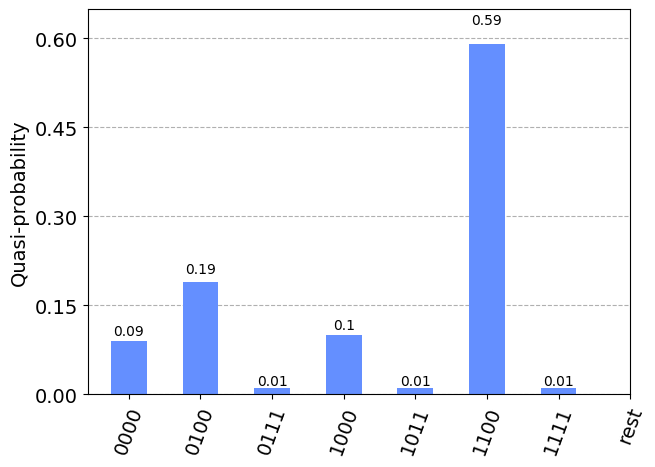

In [9]:
from qiskit.visualization import plot_distribution

quasi_distribution = result.eigenstate.binary_probabilities()
plot_distribution(quasi_distribution, number_to_keep=10)

## use the encoder to retrieve the solution

In [10]:
solutions = []
for bitstring, probability in quasi_distribution.items():
    if probability < 0.1:
        continue

    solution = encoder.translate_result_bitstring(bitstring=bitstring)

    print("probability: ", probability)
    print(solution)
    solutions.append(solution)

probability:  0.59
jssp1 solution with makespan 3
  j1:
    j1op1(m1, 1) starts at: 1 and ends at: 2
    j1op2(m2, 1) starts at: 2 and ends at: 3
  j2:
    j2op1(m1, 1) starts at: 0 and ends at: 1
    j2op2(m2, 1) starts at: 1 and ends at: 2

probability:  0.19
jssp1 solution with makespan 3
  j1:
    j1op1(m1, 1) starts at: 0 and ends at: 1
    j1op2(m2, 1) starts at: 2 and ends at: 3
  j2:
    j2op1(m1, 1) starts at: 0 and ends at: 1
    j2op2(m2, 1) starts at: 1 and ends at: 2

probability:  0.1
jssp1 solution with makespan 2
  j1:
    j1op1(m1, 1) starts at: 1 and ends at: 2
    j1op2(m2, 1) starts at: 1 and ends at: 2
  j2:
    j2op1(m1, 1) starts at: 0 and ends at: 1
    j2op2(m2, 1) starts at: 1 and ends at: 2


## Visualize the result (optional)

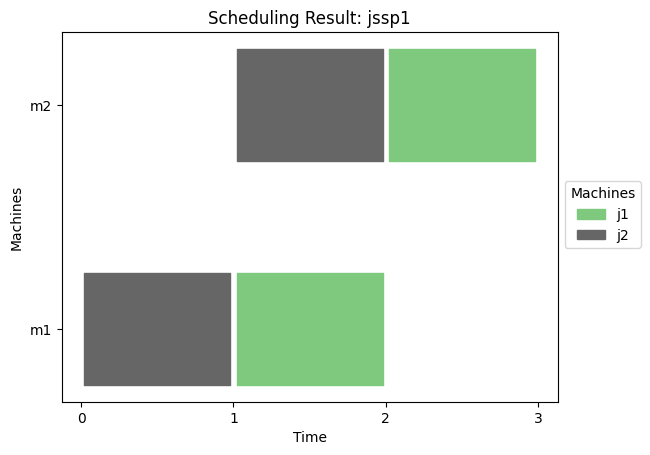

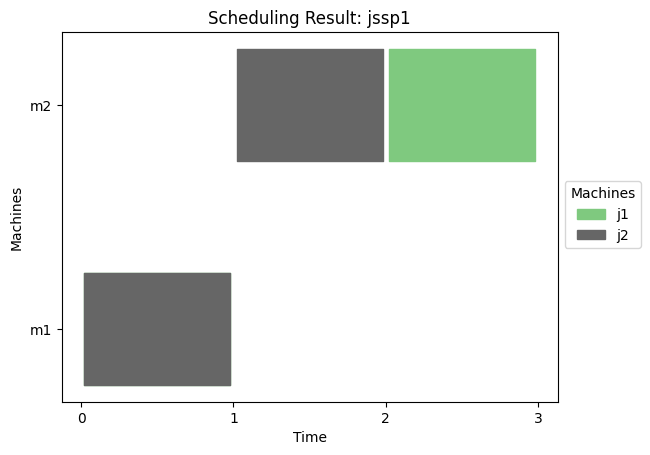

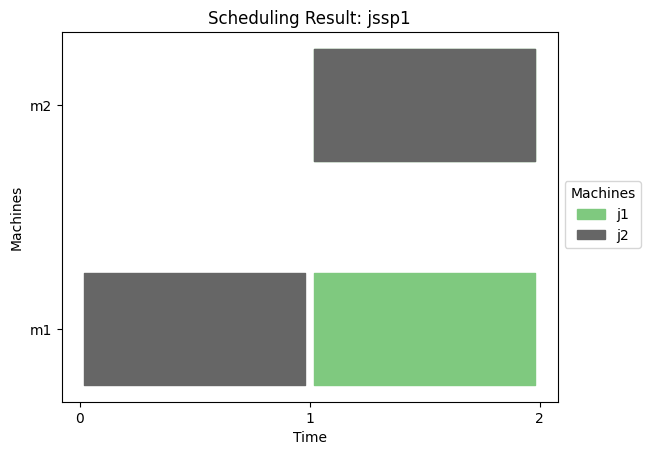

In [11]:
from queasars.job_shop_scheduling.visualization import plot_jssp_problem_solution_gantt

for solution in solutions:
    plot = plot_jssp_problem_solution_gantt(result=solution)